In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/bitirme/dataset/phoenix-2014-T.v3.tar.gz /content/phoenix-2014-T.v3.tar.gz

In [ ]:
!tar -xzvf /content/phoenix-2014-T.v3.tar.gz -C /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0002.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0042.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0039.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0045.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0037.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0030.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev/29September_2011_Thursday_heute-4235/images0021.png
PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/d

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
import random
from PIL import Image
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
def get_video_folders(root_folder, limit):
    sorted_folders = sorted([os.path.join(root_folder, d) for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))])
    if limit == 0: return sorted_folders
    else: return sorted_folders[:limit]

In [ ]:
def process_video_folder(folder_path):
    paths = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]) #sort the files
    imgs, mask = load_imgs(paths)  # Preprocess and pad/slice to 300 frames
    return imgs, mask

In [ ]:
def sample_frames(video_length, target_length=300):
    #300 values spread between 0 and video_length-1
    indices = np.linspace(0, video_length - 1, target_length)
    #Round them to nearest integers so they can serve as frame indices
    indices = np.round(indices).astype(int)
    return indices

In [ ]:
def load_imgs(paths, max_length=300, input_size=224, resize=(224, 224), is_train=False):
    """Loads and preprocesses images from the given paths, applies sampling or padding as necessary."""

    color_jitter = transforms.ColorJitter(
      brightness=0.5,  # how much to jitter brightness
      contrast=0.5,    # how much to jitter contrast
      saturation=0.5,  # how much to jitter saturation
      hue=0.1        # how much to jitter hue
    )

    """
            transforms.RandomResizedCrop(
                    size=(224,224),
                    scale=(0.875, 1),
                    ratio=(0.9, 1.1),
                ),
    """

    # Define data transformations
    data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop(size=(224,224)),
        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #subsample every second frame
    paths = paths[::2]

    frame_count = len(paths)

    # Random sampling if more than max_length frames
    if frame_count > max_length:
        pass
        #sample_frame_indices = sample_frames(frame_count, 300)
        #paths = [paths[x] for x in sample_frame_indices]
    else:
        # Zero-padding if fewer than max_length frames
        paths = paths + [0] * (max_length - frame_count)

    mask = [0 if p != 0 else 1 for p in paths]
    mask = torch.tensor(mask, dtype=torch.bool) # Convert to a PyTorch tensor

    # Initialize tensor to store images
    imgs = torch.zeros(max_length, 3, input_size, input_size)

    # Load and process each image
    for i, img_path in enumerate(paths):
        if img_path != 0:  # Skip padding elements
            img = cv2.imread(img_path)
            orig_img = img.copy()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            img = data_transform(img)
            imgs[i] = img  # Assign to tensor

            img = img.permute(1, 2, 0).numpy()
            #orig_img = orig_img.permute(1, 2, 0).numpy()

            img1_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            axs[0].imshow(img1_rgb)
            axs[0].axis('off')

            axs[1].imshow(img)
            axs[1].axis('off')

            plt.show()

    return imgs, mask  # Returns tensor of shape (max_length, 3, input_size, input_size)

In [ ]:
def generate_embeddings_for_all_videos(model, root_folder, limit, batch_size=8, device='cuda'):
    model = model.to(device).eval()  # Move model to device and set to eval mode

    video_folders = get_video_folders(root_folder, limit)  # Get video subfolders
    all_embeddings = []  # Store embeddings for each video
    masks = [] #Masks for each folder
    current_batch = []  # Collect frames for a batch of videos
    folder_batches = [video_folders[i:i + batch_size] for i in range(0, len(video_folders), batch_size)]
    for folder_batch in tqdm(folder_batches, desc="Processing videos in batches"):
        # Load and preprocess each video in the current batch
        for folder in folder_batch:
            imgs, mask = process_video_folder(folder)
            current_batch.append(imgs)  # Shape: (300, 3, H, W) for each video
            masks.append(mask)

        # Stack batch of videos and move to GPU
        batch_tensor = torch.stack(current_batch).to(device)  # Shape: (batch_size, 300, 3, H, W)

        # Flatten the batch to create a large tensor of frames
        # DINOv2 expects input in the format (batch_size, channels, height, width)
        batch_tensor = batch_tensor.view(-1, 3, 224, 224)  # Shape: (batch_size * 300, 3, H, W)

        # Generate embeddings
        with torch.no_grad():
            # Get the 'last_hidden_state' from the model output
            batch_embeddings = model(batch_tensor)  # Shape: (batch_size * 300, embedding_dim)

        # Reshape embeddings back to (batch_size, 300, embedding_dim)
        batch_embeddings = batch_embeddings.reshape(batch_size, 300, -1)

        # Move embeddings to CPU and store
        all_embeddings.extend(batch_embeddings.cpu())
        # Clear current batch for the next set
        current_batch = []

    masks_tensor = torch.stack(masks)
    return all_embeddings, masks_tensor  # List of tensors, each of shape (300, embedding_dim)

In [ ]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 166MB/s]


In [ ]:
train_root_folder = "/content/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train"
val_root_folder = "/content/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/dev"
test_root_folder = "/content/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/test"

In [ ]:
iterations = 3
train_embeddings = []
train_masks = None
for i in range(iterations):
  current_train_embeddings, current_train_masks = generate_embeddings_for_all_videos(model, train_root_folder, 0)
  train_embeddings.extend(current_train_embeddings)
  if train_masks == None: train_masks = current_train_masks.clone().detach()
  else: train_masks = torch.cat((train_masks, current_train_masks), dim=0)

val_embeddings, val_masks = generate_embeddings_for_all_videos(model, val_root_folder, 0)
print(f"\nGenerated embeddings for {len(val_embeddings)} videos.")

test_embeddings, test_masks = generate_embeddings_for_all_videos(model, test_root_folder, 0)
print(f"\nGenerated embeddings for {len(test_embeddings)} videos.")

Processing videos in batches: 100%|██████████| 65/65 [05:08<00:00,  4.75s/it]



Generated embeddings for 520 videos.


Processing videos in batches: 100%|██████████| 81/81 [06:35<00:00,  4.88s/it]


Generated embeddings for 648 videos.


In [ ]:
train_embeddings_lost = train_embeddings

In [ ]:
train_masks.shape

torch.Size([21288, 300])

In [ ]:
len(val_embeddings)

520

In [ ]:
val_masks.shape

torch.Size([519, 300])

In [ ]:
with open('/content/drive/MyDrive/dataset/val_labels.pkl', 'rb') as f:
        val_labels = pickle.load(f)
with open('/content/drive/MyDrive/dataset/test_labels.pkl', 'rb') as f:
        test_labels = pickle.load(f)
with open('/content/drive/MyDrive/dataset/train_labels.pkl', 'rb') as f:
        labels = pickle.load(f)

In [ ]:
train_labels = labels * 3

In [ ]:
len(train_labels)

21288

In [ ]:
import pickle
import h5py

In [ ]:
def save_hdf5(embeddings, labels, masks, output_path):
    with h5py.File(output_path, 'w') as hf:
        hf.create_dataset('embeddings', data=np.array(embeddings, dtype=np.float32), compression="gzip")
        hf.create_dataset('labels', data=np.array(labels, dtype=np.int64))
        hf.create_dataset('masks', data=np.array(masks, dtype=bool))

In [ ]:
len(train_embeddings)

21288

In [ ]:
save_hdf5(train_embeddings,
          train_labels,
          train_masks,
          '/content/drive/MyDrive/dataset/augmented_v2_train_data.h5')

In [ ]:
for i, emb in enumerate(test_embeddings):
    print(f"Embedding {i} : {emb.shape}")

Embedding 0 : torch.Size([300, 384])
Embedding 1 : torch.Size([300, 384])
Embedding 2 : torch.Size([300, 384])
Embedding 3 : torch.Size([300, 384])
Embedding 4 : torch.Size([300, 384])
Embedding 5 : torch.Size([300, 384])
Embedding 6 : torch.Size([300, 384])
Embedding 7 : torch.Size([300, 384])
Embedding 8 : torch.Size([300, 384])
Embedding 9 : torch.Size([300, 384])
Embedding 10 : torch.Size([300, 384])
Embedding 11 : torch.Size([300, 384])
Embedding 12 : torch.Size([300, 384])
Embedding 13 : torch.Size([300, 384])
Embedding 14 : torch.Size([300, 384])
Embedding 15 : torch.Size([300, 384])
Embedding 16 : torch.Size([300, 384])
Embedding 17 : torch.Size([300, 384])
Embedding 18 : torch.Size([300, 384])
Embedding 19 : torch.Size([300, 384])
Embedding 20 : torch.Size([300, 384])
Embedding 21 : torch.Size([300, 384])
Embedding 22 : torch.Size([300, 384])
Embedding 23 : torch.Size([300, 384])
Embedding 24 : torch.Size([300, 384])
Embedding 25 : torch.Size([300, 384])
Embedding 26 : torch.S

In [ ]:
test_embeddings = test_embeddings[:640]

In [ ]:
test_masks = test_masks[:640]

In [ ]:
test_masks.shape

torch.Size([640, 300])

In [ ]:
save_hdf5(val_embeddings,
          val_labels,
          val_masks,
          '/content/drive/MyDrive/dataset/val_data_v2.h5')

In [ ]:
save_hdf5(test_embeddings,
          test_labels,
          test_masks,
          '/content/drive/MyDrive/dataset/test_data_v2.h5')

In [ ]:
drive.flush_and_unmount()

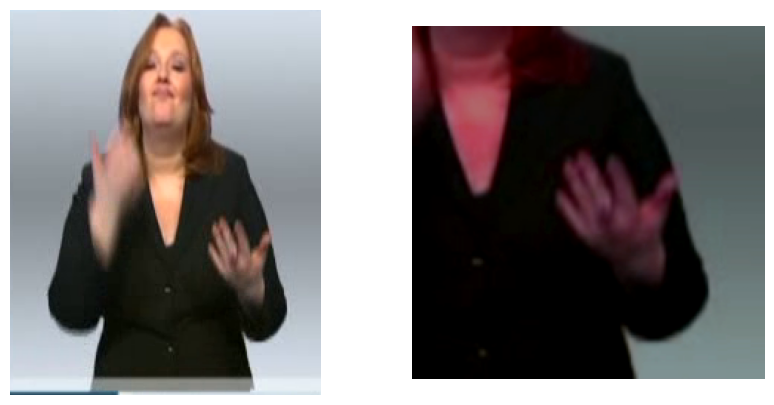

.


In [ ]:
paths = [
    "/content/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/01April_2010_Thursday_heute-6694/images0007.png"
]
load_imgs(paths)
print(".")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
with open('/content/drive/MyDrive/dataset/val_embeddings.pkl', 'rb') as f:
        saved_val = pickle.load(f)

In [ ]:
len(saved_val)

512